In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

In [3]:
num_epochs = 25
percentage_of_train_dataset = 0.20 #Out of 60K Image (To Speed up Training)
percentage_of_test_dataset = 0.20 # Out of 10K Images (To Speed up Testing)


loss_history =[]
acc_history =[]
min_loss = 9999 #To implement Simple Early Stopping
no_improvement_epoch = 0 #To implement Simple Early Stopping


https://github.com/deepinsight/insightface/blob/master/recognition/arcface_torch/losses.py

In [4]:
class ArcLoss(nn.Module):
    def __init__(self, num_classes, embedding_size, scale=2.0, margin=3.0):
        super(ArcLoss, self).__init__()

        
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.scale = scale
        self.margin = margin
        self.threshold = torch.cos(torch.tensor(np.pi - margin))
        margin = torch.Tensor([margin])
        self.cos_m = torch.cos(margin)
        self.sin_m = torch.sin(margin)
 
      

    def forward(self, inputs, labels):
        # Normalize feature vectors
        logits = F.normalize(inputs, p=2, dim=1)
        
        # Compute arc cosine
        arc = torch.acos(torch.clamp(logits, -1.0 + torch.finfo(torch.float32).eps, 1.0 - torch.finfo(torch.float32).eps))

        # Compute arcface loss
        target_cos = torch.cos(arc + self.margin)
        one_hot = torch.zeros_like(logits)
        one_hot.scatter_(1, labels.view(-1, 1), 1)
        output = one_hot * target_cos + (1.0 - one_hot) * logits
        output *= self.scale
        loss = F.cross_entropy(inputs, labels).mean()

        return loss

In [5]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

In [6]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./mnist_data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./mnist_data', train=False, transform=transform, download=True)

indices = np.arange(len(train_dataset))
indices2 = np.arange(len(test_dataset))

train_indices, _ = train_test_split(indices, train_size=percentage_of_train_dataset, stratify=train_dataset.targets)
test_indices, _ = train_test_split(indices2, train_size=percentage_of_test_dataset, stratify=test_dataset.targets)

# Warp into Subsets and DataLoaders
train_dataset = Subset(train_dataset, train_indices)
test_dataset = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [7]:

# Define model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(1152, 512)  # Corrected input size
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # print(x.shape)  # Print shape for debugging
        x = x.view(-1, 1152)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [8]:
model = Net()

# Define ArcLoss criterion and optimizer
criterion = ArcLoss(num_classes=10, embedding_size=128)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
# Training loop

model.to(device)

# Training loop


for epoch in range(num_epochs):

    model.train()
    avg_loss = 0
    loop_count = 0

    for images, labels in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(images.to(device))
        loss = criterion(output, labels.to(device))
        # print("op:", output, type(output), output.shape)
        # print("lb:", labels, type(labels), labels.shape)
        loss.backward()
        optimizer.step()
        
        loop_count +=1
        avg_loss += loss.tolist()

    avg_loss /= loop_count
    print("Avg Loss:", avg_loss)

    loss_history.append(avg_loss)


    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            output = model(images.to(device))
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            # print(predicted.shape, labels.shape)
            correct += (predicted == labels.to(device)).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')

    acc_history.append(accuracy)


    if avg_loss < min_loss:
        min_loss = avg_loss
        # print("Model Improved")
        no_improvement_epoch = 0
    else:
        # print("No Improvement")
        no_improvement_epoch += 1
    
    if no_improvement_epoch > 10:
        print("Early Stopping, No Improvement since few Epochs")
        break


print('Training Finished')

  0%|          | 0/94 [00:00<?, ?it/s]

100%|██████████| 94/94 [00:35<00:00,  2.62it/s]


Avg Loss: 1.79761037674356


100%|██████████| 16/16 [00:03<00:00,  5.09it/s]


Epoch [1/25], Test Accuracy: 88.50%


100%|██████████| 94/94 [00:31<00:00,  3.02it/s]


Avg Loss: 0.8013439812558762


100%|██████████| 16/16 [00:04<00:00,  3.88it/s]


Epoch [2/25], Test Accuracy: 94.30%


 95%|█████████▍| 89/94 [00:34<00:01,  2.53it/s]

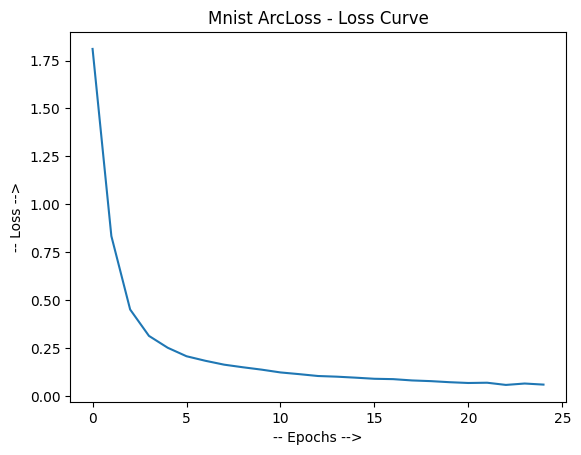

In [ ]:
plt.plot(loss_history)
plt.title("Mnist ArcLoss - Loss Curve")
plt.xlabel("-- Epochs -->")
plt.ylabel("-- Loss -->")
plt.savefig("arcloss_mnist_loss.png")
plt.show()

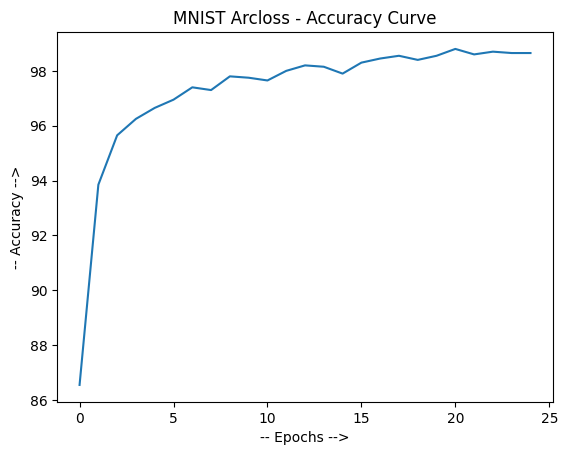

In [ ]:
plt.plot(acc_history)
plt.title("MNIST Arcloss - Accuracy Curve")
plt.xlabel("-- Epochs -->")
plt.ylabel("-- Accuracy -->")
plt.savefig("arcloss_mnist_accuracy.png")
plt.show()

In [ ]:
# Model accuracy testing
model.eval()
correct = 0
total = 0
optimizer.zero_grad()
with torch.no_grad():
    for data in tqdm(test_loader, desc="Testing"):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the MNIST test set: {(100 * correct / total):.2f}%")

Testing: 100%|██████████| 16/16 [00:00<00:00, 45.49it/s]

Accuracy on the MNIST test set: 98.65%


In [ ]:
# Test the Model

all_labels = []
all_predicted = []

with torch.no_grad():
    for data in tqdm(test_loader):
        images, labels = data
        labels = labels.to(device)
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        
        for lbl in labels.tolist():
            all_labels.append(lbl)

        for pred in predicted.tolist():
            all_predicted.append(pred)

accuracy = metrics.accuracy_score(all_labels, all_predicted)
precision = metrics.precision_score(all_labels, all_predicted, average="weighted")
print("Accuracy:", accuracy)
print("Precision:", precision)

100%|██████████| 16/16 [00:00<00:00, 44.08it/s]

Accuracy: 0.9865
Precision: 0.9866670423647915


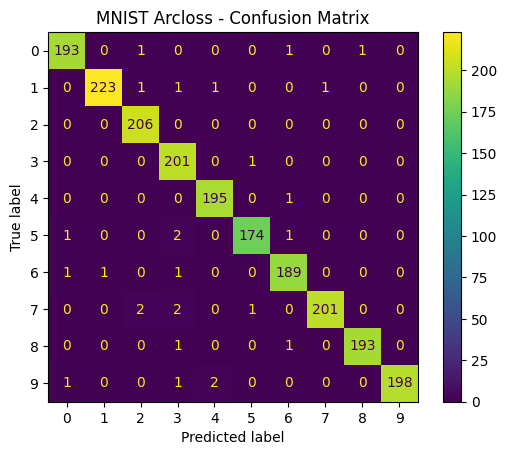

In [ ]:
confusion_matrix = metrics.confusion_matrix(all_labels, all_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.title("MNIST Arcloss - Confusion Matrix")
plt.savefig("arcloss_mnist_cm.png")
plt.show()